<a href="https://colab.research.google.com/github/sruthi1996/DeepLearning/blob/master/MNIST_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MNIST classification using Numpy- Assignment-1**


Importing the MNIST dataset using Keras; the handwritten digits will be used for classification using neural networks.
Also, the Image data generator API from keras has been used for Image Augmentation.
**Image Augmentation** is a technique where batches of image data will be generated. This creates artificial images using multiple ways like rotations, flips or shifts.

In [0]:
from keras.datasets import mnist
from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import random


In [0]:
#Download the MNIST data; dataset contains data for both training and testing
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()


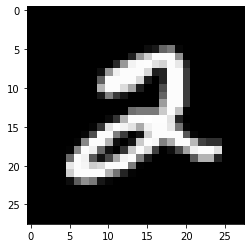

In [47]:
import matplotlib.pyplot as plt
plt.imshow(X_train[5], cmap=plt.get_cmap('gray'))
plt.show()

The Y labels or the target in both train and test data are digits ranging from 0 to 9, which have to be converted into vectors; 

In [0]:
from keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)

Now, to perform Normalization on the dataset; we are using **grayscale**. In **grayscale normalization**; the Min and Max values which are between 0 and 255 change to a new set of minimum and maximum values i.e. between 0 and 1.

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Now, we have to reshape the dataset into  the 784 pixel values i.e. into 3 dimensions; 

In [50]:
X_train = X_train.reshape(-1,28,28,1)
print(X_train.shape)

#X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
#X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

(60000, 28, 28, 1)


Similarily doing it for test data; 

In [51]:
X_test = X_test.reshape(-1,28,28,1)
print(X_test.shape)

(10000, 28, 28, 1)


AS mentioned above; using an API from keras to perform image augmentation.

In [0]:
datageneration = ImageDataGenerator(zoom_range=0.5, width_shift_range=0.05, height_shift_range=0.05)
datageneration.fit(X_train)

To perform training using neural networks, we have to define **foward and backward propagation functions**; also defining suitable **activation function**.

In [0]:
class Layer_NN:
    def __init__(self, in_neurons, out_neurons, dropout_value=0.3, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.weights = np.random.randn(in_neurons, out_neurons) * 0.01
        self.biases = np.zeros(out_neurons)

    def forwardprop(self, input_activation):
        activations = np.matmul(input_activation, self.weights) + self.biases
        return activations

    def backwardprop(self, input_activation, grad_output):
        grad_input = np.dot(grad_output, np.transpose(self.weights))

        # Gradient with Weights
        grad_weights = np.transpose(np.dot(np.transpose(grad_output), input_activation))
        # Gradient with Biases
        grad_biases = np.sum(grad_output, axis=0)

        # Stochastic Gradient Descent.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        return grad_input

Defining **Rectified Linear Unit**(RELU function):

In [0]:
class Relu:
    @staticmethod
    def forwardprop(input_activation):
        return (input_activation > 0) * input_activation

    @staticmethod
    def backwardprop(input_activation, grad_output):
        return (input_activation > 0) * grad_output

The **Relu function ranges the values with between 0 and any positive value.** We have used Relu activation function along with forward and backward propagation.
Now, We have to define a **dropout layer** which nulls the activation value of certain neurons; The **drop_value** defined below is nothing but a **treshold** value used for dropout.

In [0]:
class Dropout_fxn:
    @staticmethod
    def generate_dropout_mask(size, dropout_value):
        zeros_size = int(size * dropout_value)
        zeros = np.zeros(zeros_size)
        ones = np.ones(size - zeros_size)
        dropout_mask = np.asarray(zeros.tolist() + ones.tolist())
        random.shuffle(dropout_mask)
        return dropout_mask

    def __init__(self, size, dropout_value=0.20):
        self.dropout_mask = Dropout_fxn.generate_dropout_mask(size, dropout_value)

    def forwardprop(self, input_activation):
        return np.multiply(input_activation, self.dropout_mask)

    def backwardprop(self, input_activation, grad_output):
        return np.multiply(grad_output, self.dropout_mask)

In [0]:
neural_network = [
    Layer_NN(X_train.shape[1] * X_train.shape[2], 200),
    Dropout_fxn(200, 0.20),
    Relu(),
    Layer_NN(200, 100),
    Dropout_fxn(100, 0.10),
    Relu(),
    Layer_NN(100, 10)
]

In [0]:
def softmaxerr(out_activations, y):
    softmax = np.exp(out_activations) / np.exp(out_activations).sum(axis=-1, keepdims=True)
    return softmax - y

In [0]:
def get_activations(X):
    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
    activations = []
    for level in range(len(neural_network)):
        next_activations = neural_network[level].forwardprop(X)
        activations.append(next_activations)
        X = next_activations
    return activations

In [59]:
def trainfxn(X, y):
    activations = get_activations(X)
    output_activations = activations[-1]

    loss = softmaxerr(output_activations, y)
    for i in range(1, len(neural_network)):
        network = neural_network[len(neural_network) - i]
        loss = network.backwardprop(activations[len(neural_network) - i - 1], loss)

      
def prediction_NN(X):
    out_activations = get_activations(X)[-1]
    return out_activations.argmax(axis=-1)


def train_datagen(datageneration, total_iterations):
  for iteration in range(total_iterations):
      minibatch_iterations = 70
      for X_batch, y_batch in datageneration.flow(X_train, Y_train, batch_size=8):
          trainfxn(X_batch.reshape(-1, X_batch.shape[1], X_batch.shape[2]), y_batch)
          minibatch_iterations -= 1
          if minibatch_iterations == 0:
              break
      print("***Iteration: {}***".format(iteration))
      train_result = [np.mean(prediction_NN(X_train) == Y_train.argmax(axis=-1))]
      print("Train accuracy: {}%".format(train_result[-1] * 100))
      test_result = [np.mean(prediction_NN(X_test) == Y_test.argmax(axis=-1))]
      print("Test accuracy: {}%".format(test_result[-1] * 100))

# Training the model with Augumented data generated
train_datagen(datageneration, 110)

***Iteration: 0***
Train accuracy: 9.871666666666666%
Test accuracy: 9.8%
***Iteration: 1***
Train accuracy: 9.915000000000001%
Test accuracy: 10.09%
***Iteration: 2***
Train accuracy: 17.625%
Test accuracy: 18.3%
***Iteration: 3***
Train accuracy: 34.901666666666664%
Test accuracy: 35.47%
***Iteration: 4***
Train accuracy: 38.975%
Test accuracy: 39.71%
***Iteration: 5***
Train accuracy: 55.794999999999995%
Test accuracy: 55.2%
***Iteration: 6***
Train accuracy: 56.779999999999994%
Test accuracy: 57.54%
***Iteration: 7***
Train accuracy: 46.845%
Test accuracy: 47.85%
***Iteration: 8***
Train accuracy: 57.95%
Test accuracy: 58.3%
***Iteration: 9***
Train accuracy: 56.06166666666667%
Test accuracy: 56.43%
***Iteration: 10***
Train accuracy: 25.106666666666666%
Test accuracy: 25.990000000000002%
***Iteration: 11***
Train accuracy: 65.69333333333334%
Test accuracy: 66.28%
***Iteration: 12***
Train accuracy: 65.03333333333333%
Test accuracy: 65.0%
***Iteration: 13***
Train accuracy: 56.5366

In [60]:
from sklearn.metrics import confusion_matrix
y_pred = prediction_NN(X_test)
print('confusion matrix on test set:\n', confusion_matrix(Y_test.argmax(axis=-1), y_pred))
final_test_accuracy = np.mean(prediction_NN(X_test) == Y_test.argmax(axis=-1)) * 100
print("Final Test Accuracy: {}%".format(final_test_accuracy))

confusion matrix on test set:
 [[ 868    2    2    3   17   30    2    9   30   17]
 [   0 1116    1    4    0    1    2    0   11    0]
 [   2   17  763   30   14    5   26   33  136    6]
 [   0    3    5  840    3   53    1    3   95    7]
 [   1    1    2    1  825    7   34    0   67   44]
 [   7    7    2   72    6  730    7    2   56    3]
 [   9    2    2    3   72   34  756    1   78    1]
 [   4   19   18   27    6    9    1  808   54   82]
 [   2   10    0   15    9   19    4    2  903   10]
 [   2    3    6   30  219   19    3   14  161  552]]
Final Test Accuracy: 81.61%


Hence, with a 3 layered network; the accuracy has been 81.6% on the test data.